In [1]:
import re 
import os 
from collections import Counter

import numpy as np 
import pandas as pd 

from scipy.stats import linregress 

from sklearn.metrics import mean_absolute_error as l1_score 
from sklearn.metrics import mean_squared_error as l2_score
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt 

import warnings 
warnings.filterwarnings("ignore")

In [2]:
class file_obj: 
    
    def __init__(self, year_str, demo_file, mental_file, drug_file): 
        self.name = year_str 
        self.demo = demo_file 
        self.mental = mental_file
        self.drug = drug_file
        temp = demo_file.merge(mental_file, how='left', on=['SEQN'])
        self.merged = temp.merge(drug_file, how='left', on=['SEQN'])
        
    def __repr__(self):
        return self.name

def weighted_value(source_col, weight_col, percentage=True):
    unique_values = source_col.unique()
    mapping_dict = {}
    
    for value in unique_values: 
        binary = source_col == value
        weighted = binary * weight_col
        result = round(weighted.sum() / weight_col.sum(), 5) if percentage else weighted.sum()
        mapping_dict[value] = result
    return mapping_dict

def not_nan_index(tables):
    assert isinstance(tables, list)
    
    result = tables[0].notna()    
    for table in tables[1:]:
        result = result & table.notna()
    return result 

def map_to_nan_3(value):
    return value if 0 <= value <= 3 else np.nan 

def map_to_nan_30(value):
    return value if value <= 30 else np.nan


def find_na(value):
    return True if value > 3 else False

year_mapping = {letter: f'{year}-{year+1}' for year, letter in enumerate('A B C D E F G H I J K L', 1999)}

In [3]:
records = [] 

year_regex = re.compile(r'.*_([A-Z]{1}).*')

files = list(filter(lambda item: item.endswith('XPT'), os.listdir('data')))
files.sort(key=lambda item: year_regex.search(item).groups()[0])

for index in range(0, len(files), 3):
    print(f'\r{index}', end='', flush=True)
    demo_name, mental_name, drug_name = files[index], files[index+1], files[index+2]
    year = year_mapping[year_regex.search(demo_name).groups()[0]]
    
    demo_file, mental_file, drug_file = pd.read_sas(f'data/{demo_name}'), pd.read_sas(f'data/{mental_name}'), pd.read_sas(f'data/{drug_name}')
    
    package = (demo_file, mental_file, drug_file)
    package = [table.fillna(-100).astype(int).replace(-100, np.nan) for table in package]
    package = file_obj(year, *package)
    package.mental['DPQ010'], package.drug['DUQ230']
    records.append(package)

18

In [4]:
drug = []
depression = [] 
mental_columns = [f'DPQ{number:02}0' for number in range(1, 11)]

for file in records: 
    
    score_table = file.merged[['SEQN'] + ['DUQ230'] + mental_columns].copy()
    score_table[mental_columns] = score_table[mental_columns].applymap(map_to_nan_3)
    score_table['DUQ230'] = score_table['DUQ230'].map(map_to_nan_30)
    
    score_table.dropna(inplace=True)
    score_table['depression_score'] = score_table[mental_columns].sum(axis=1)

    merged_table = file.merged.copy() 
    merged_table = merged_table.loc[merged_table['SEQN'].isin(score_table['SEQN'])]
    merged_table = merged_table.merge(score_table[['SEQN', 'depression_score']], how='left')

    drug.append(merged_table['DUQ230'])
    depression.append(merged_table['depression_score'])

In [5]:
year = list(range(1, 8))
mental_mean = [file.mean() for file in depression]
drug_mean = [file.mean() for file in drug]

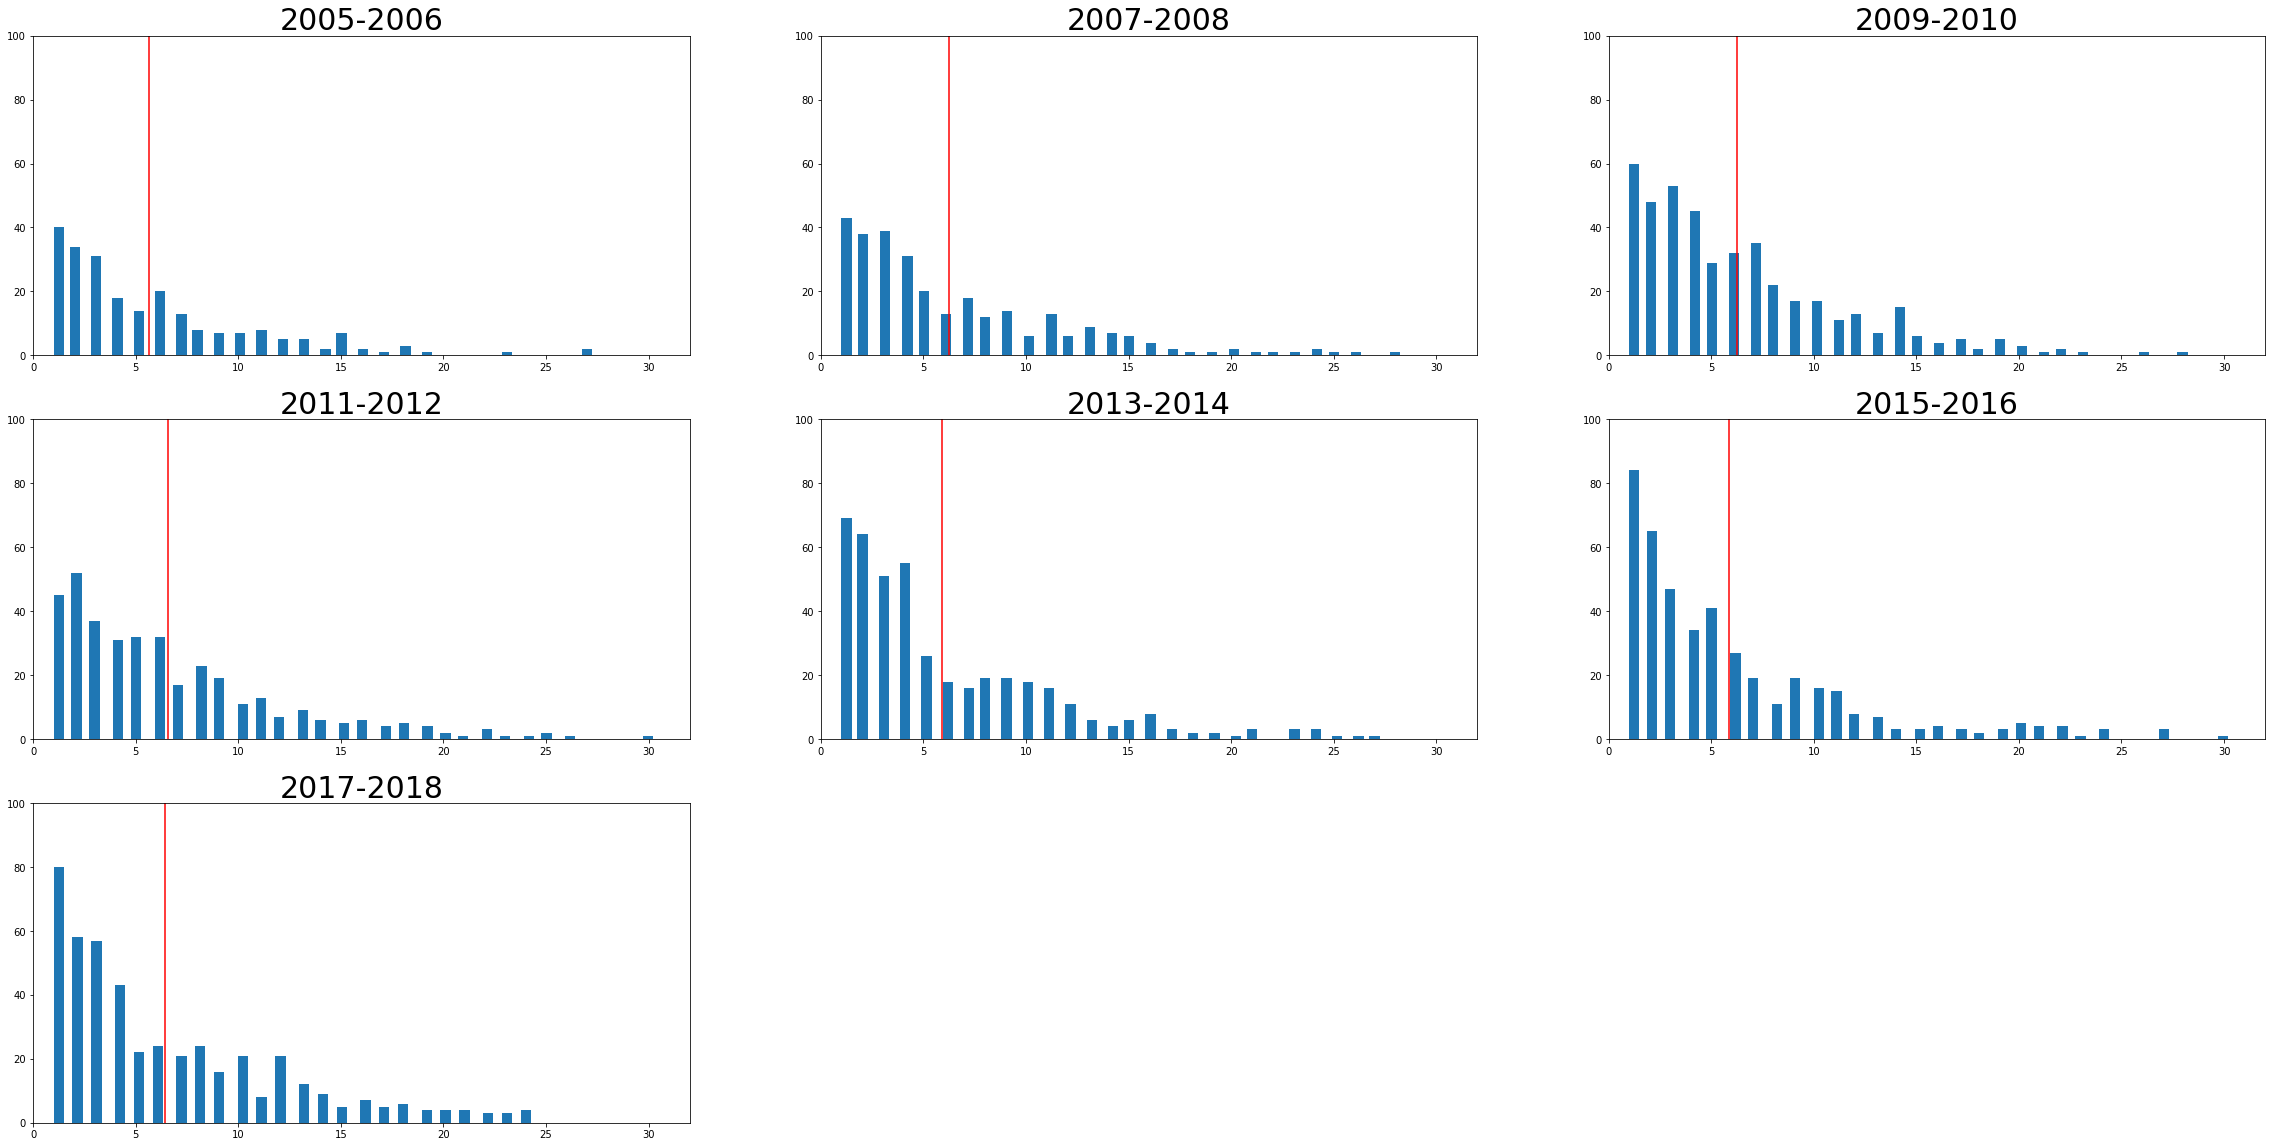

In [6]:
plt.figure(figsize=(40, 20))

rows = cols = 3 

for index, file in enumerate(depression, 1): 
    plt.subplot(rows, cols, index)
    plt.hist(file, bins=100, width=0.5, align='mid')
    
    offset = 2 * index - 1 
    plt.title(f'{2004+offset}-{2005+offset}', fontdict={'size': 30})
    plt.axvline(file.mean(), color='red')
    plt.xlim(0, 32)
    plt.ylim(0, 100)
    
plt.show()

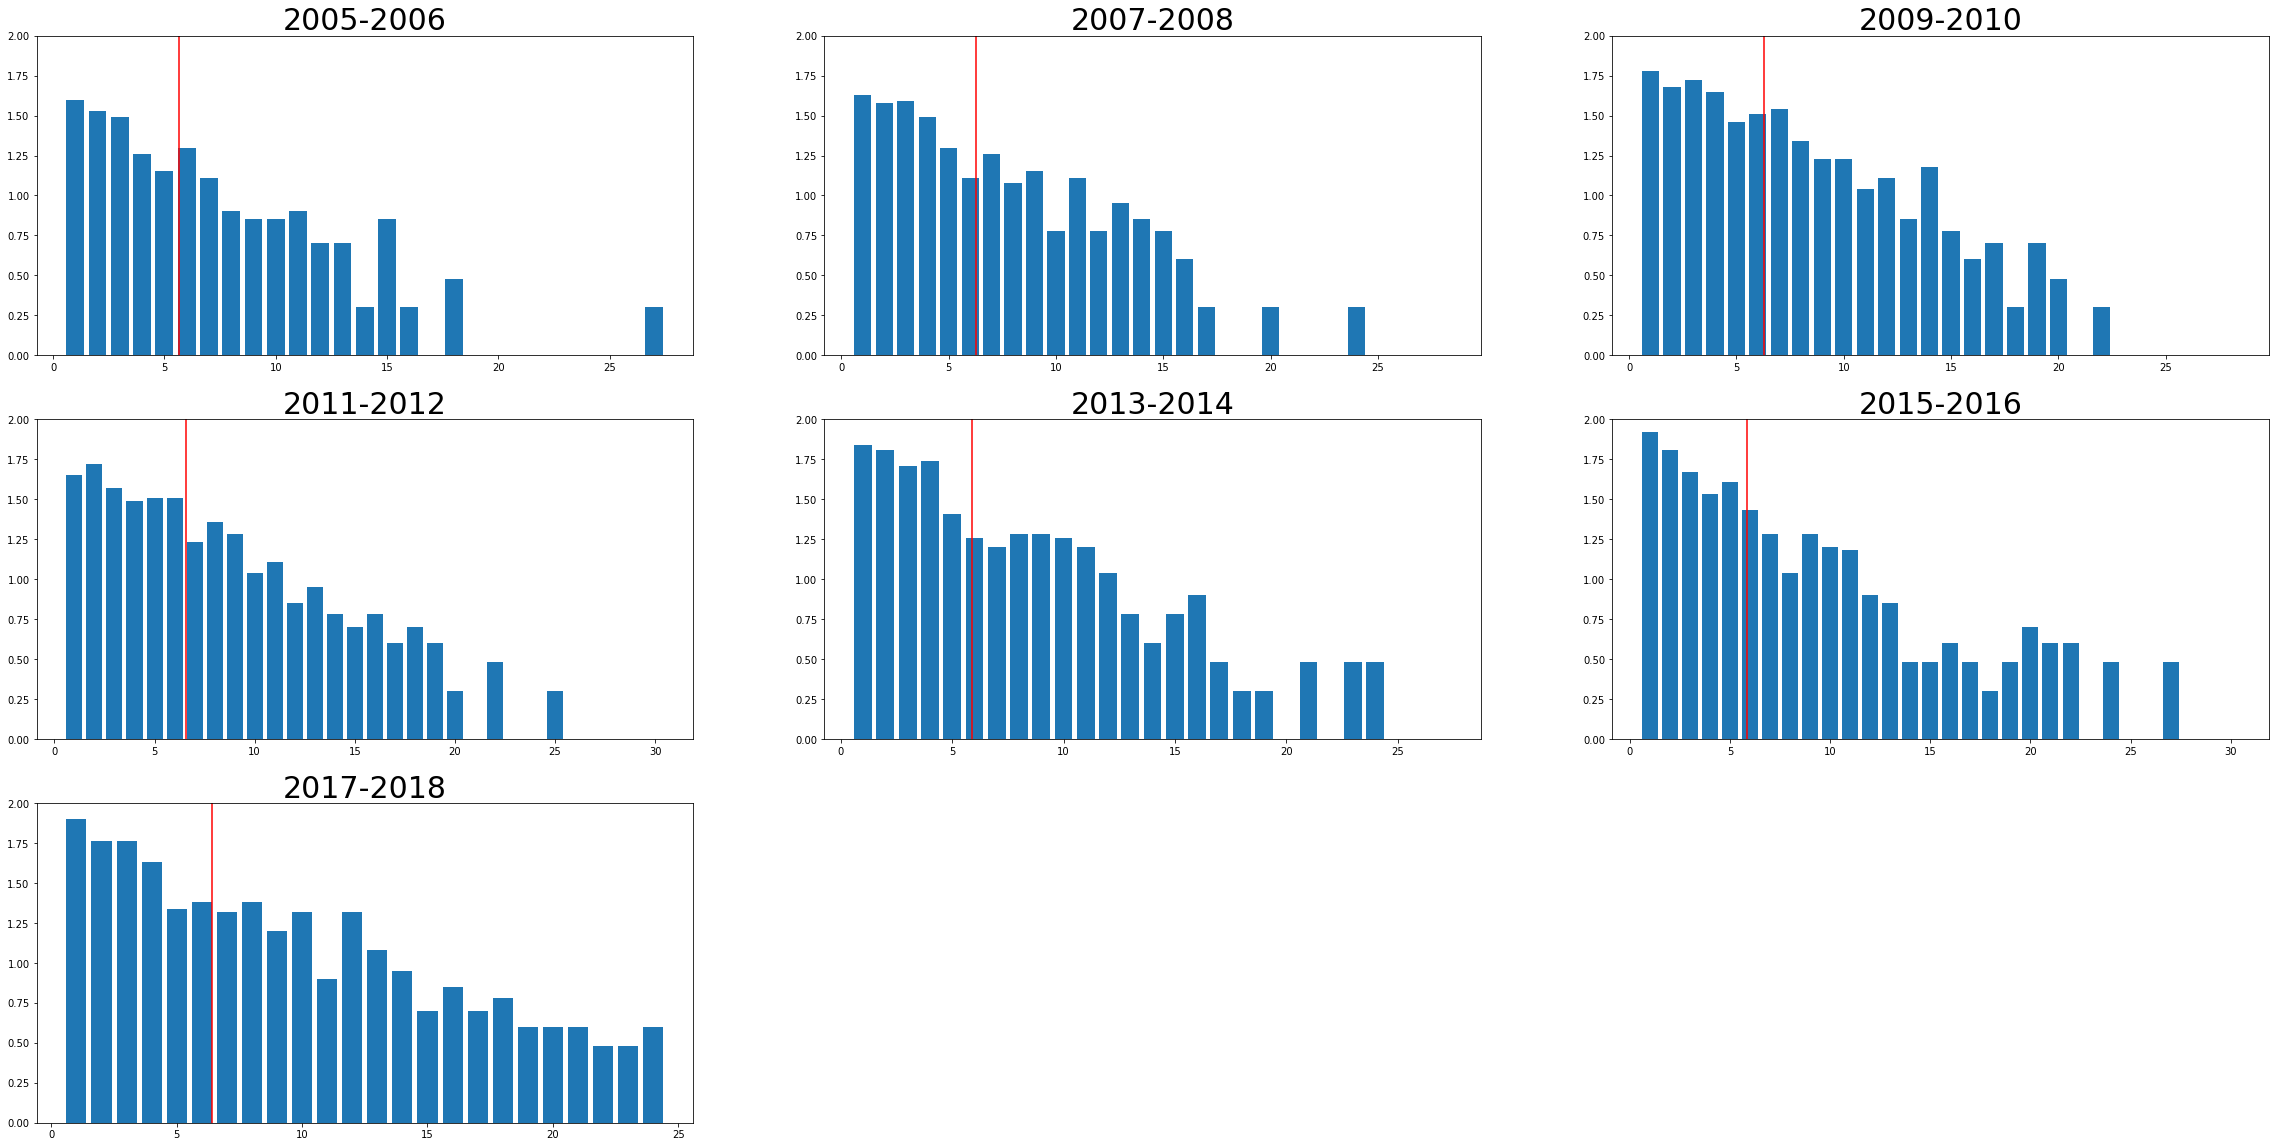

In [7]:
plt.figure(figsize=(40, 20))

rows = cols = 3 

for index, file in enumerate(depression, 1): 
    plt.subplot(rows, cols, index)
    x_coord = [] 
    loged_size = [] 
    
    data = Counter(file.to_numpy().flatten()).items()
    [(x_coord.append(key), loged_size.append(round(np.log10(values), 2))) for key, values in data]
    
    plt.bar(x_coord, loged_size)
    
    offset = 2 * index - 1 
    plt.title(f'{2004+offset}-{2005+offset}', fontdict={'size': 30})
    plt.axvline(file.mean(), color='red')
    plt.ylim(0, 2)
    
plt.show()

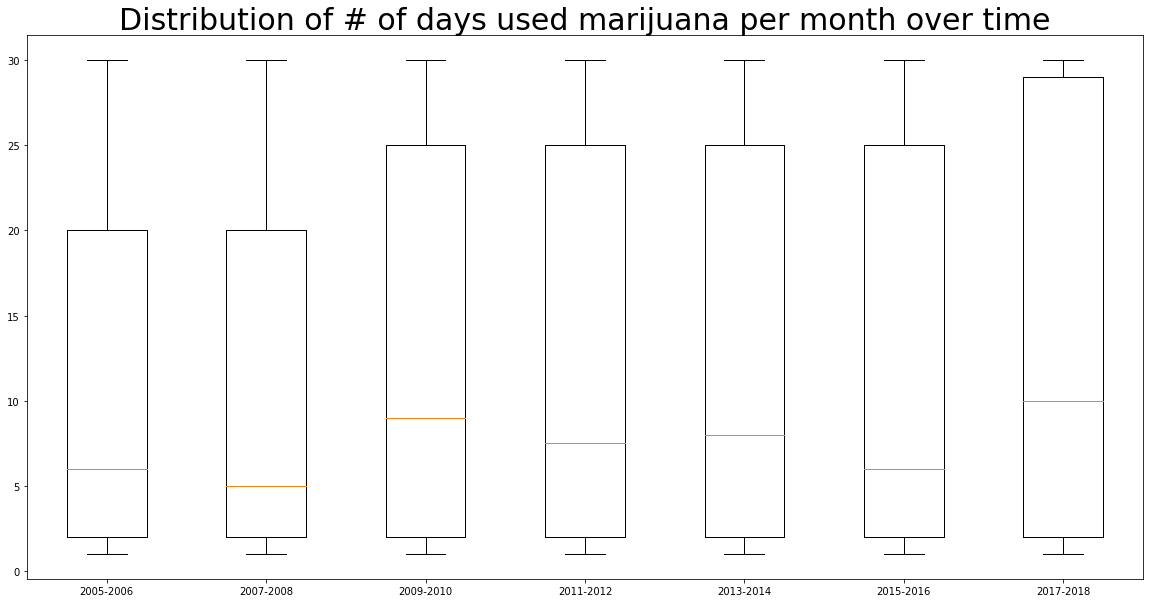

In [8]:
plt.figure(figsize=(20, 10))

plt.boxplot(drug)

plt.title('Distribution of # of days used marijuana per month over time', fontdict={'size': 30})
plt.xticks(range(1, 8), [f'{year}-{year+1}' for year in range(2005, 2018, 2)])
plt.show()

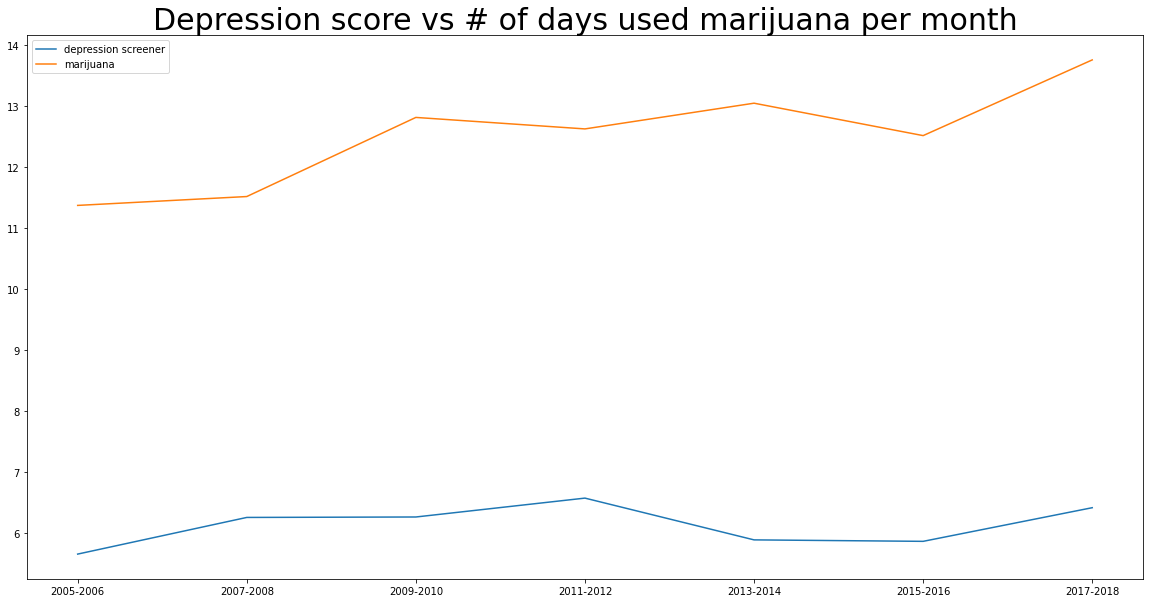

In [9]:
plt.figure(figsize=(20, 10))

plt.plot(range(7), [file.mean()  for file in depression], label='depression screener')
plt.plot(range(7), [file.mean() for file in drug], label='marijuana')

plt.title('Depression score vs # of days used marijuana per month', fontdict={'size':30})
plt.xticks(range(7), [f'{year}-{year+1}' for year in range(2005, 2018, 2)])
plt.legend()
plt.show()

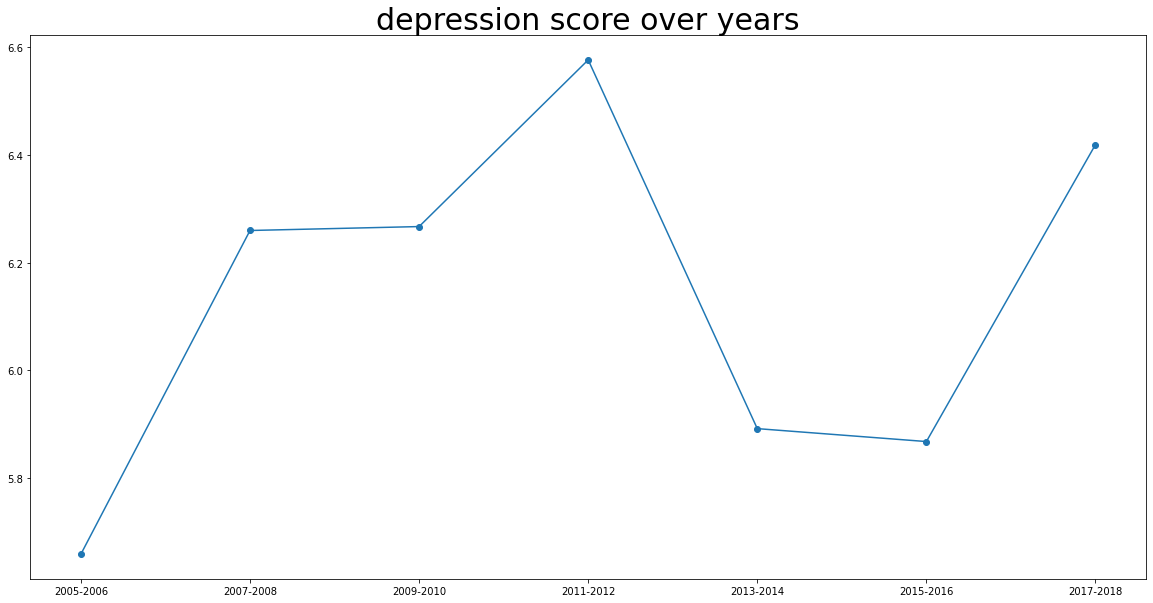

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(year, mental_mean)
plt.scatter(year, mental_mean, marker='o')

plt.xticks(year, [f'{year}-{year+1}' for year in range(2005, 2018, 2)])
plt.title('depression score over years', fontdict={'size':30})
plt.show()

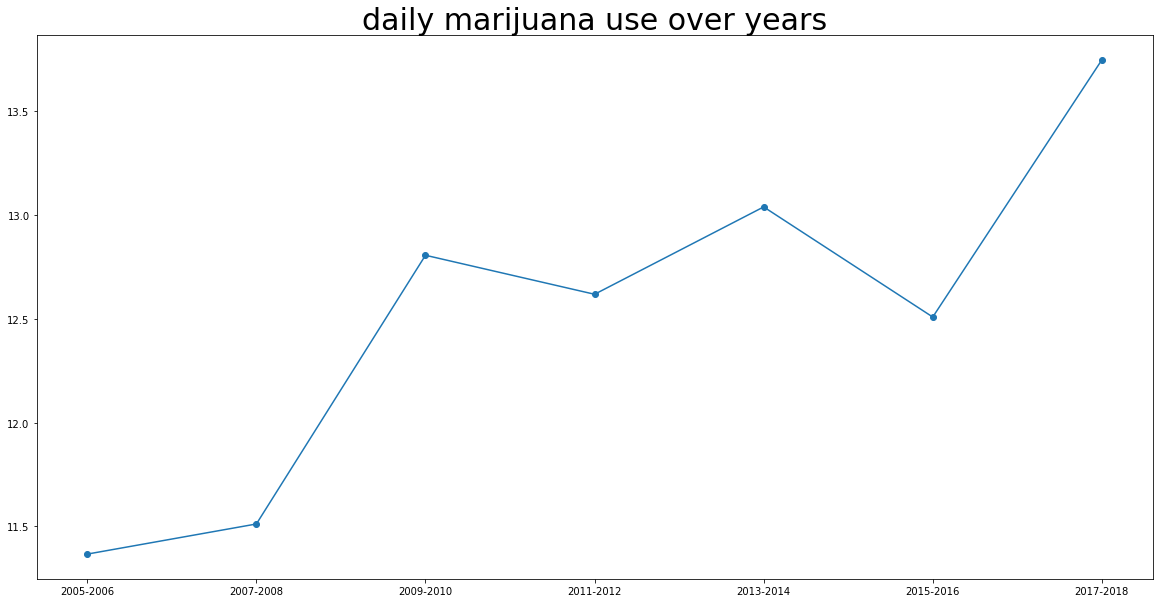

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(year, drug_mean)
plt.scatter(year, drug_mean, marker='o')

plt.xticks(year, [f'{year}-{year+1}' for year in range(2005, 2018, 2)])
plt.title('daily marijuana use over years', fontdict={'size':30})
plt.show()

<Axes3DSubplot:>

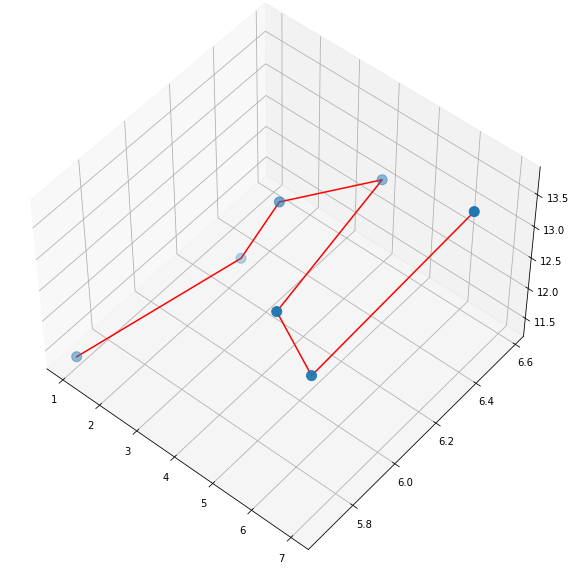

In [12]:
from mpl_toolkits import mplot3d

plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')

year = [] 
mental_mean = [] 
drug_mean = [] 


for index, package in enumerate(zip(depression, drug), 1): 
    year.append(index), mental_mean.append(package[0].mean()), drug_mean.append(package[1].mean())

ax.plot3D(year, mental_mean, drug_mean, color='red')
ax.scatter3D(year, mental_mean, drug_mean, s=100)
ax.view_init(50, -50)
ax

In [13]:
mental_columns = [f'DPQ{number:02}0' for number in range(1, 11)]

desired_column = None

for index, file in enumerate(records, 1): 
    
    # prep data for modeling, filter out invalid answers
    score_table = file.merged[['SEQN'] + ['DUQ230'] + mental_columns].copy()
    score_table[mental_columns] = score_table[mental_columns].applymap(map_to_nan_3)
    score_table['DUQ230'] = score_table['DUQ230'].map(map_to_nan_30)
    
    # calcualte depression score 
    score_table.dropna(inplace=True)
    score_table['depression_score'] = score_table[mental_columns].sum(axis=1)
    
    # merge base on sequence number 
    merged_table = file.merged.copy() 
    merged_table = merged_table.loc[merged_table['SEQN'].isin(score_table['SEQN'])]
    merged_table = merged_table.merge(score_table[['SEQN', 'depression_score']], how='left')
    
    merged_table.fillna(value=-100, inplace=True)
    
    # stash all data for later modeling 
    merged_table['year'] = index
    
    if desired_column is None:
        desired_column = set(merged_table.columns)
    else:
        desired_column = set(merged_table.columns).intersection(desired_column)
        
desired_column = list(desired_column)

In [14]:
master_table = pd.DataFrame()

rf_models = [] 
for index, file in enumerate(records, 1): 
    print('-'*80, f'\n{file.name=}')
    # prep data for modeling, filter out invalid answers
    score_table = file.merged[['SEQN'] + ['DUQ230'] + mental_columns].copy()
    score_table[mental_columns] = score_table[mental_columns].applymap(map_to_nan_3)
    score_table['DUQ230'] = score_table['DUQ230'].map(map_to_nan_30)
    
    score_table.dropna(inplace=True)
    score_table['depression_score'] = score_table[mental_columns].sum(axis=1)
    
    # merge base on sequence number 
    merged_table = file.merged.copy() 
    merged_table = merged_table.loc[merged_table['SEQN'].isin(score_table['SEQN'])]
    merged_table = merged_table.merge(score_table[['SEQN', 'depression_score']], how='left')
    
    merged_table.fillna(value=-100, inplace=True)
    
    # stash all data for later modeling 
    merged_table['year'] = index
    merged_table = merged_table[desired_column]
    master_table = pd.concat([master_table, merged_table])
    
    # train test split 
    target = merged_table['depression_score']
    merged_table.drop(columns=['SEQN', 'depression_score'] + mental_columns, inplace=True)
    print(f'merged_table shape: ', merged_table.shape)
    
    train_x, test_x, train_y, test_y = train_test_split(merged_table, target, test_size=0.2)    
    
    # calcualte depression score 
    k, b, _, _, _ = linregress(train_x['DUQ230'], train_y)
    print()
    print(linregress(train_x['DUQ230'], train_y))    
    prediction = test_x['DUQ230'] * k + b 
    print(f'L1: {l1_score(test_y, prediction)}')
    print(f'L2: {l2_score(test_y, prediction)}')    
    print()
    
    # train 
    model = RandomForestRegressor(n_estimators=100_000, max_depth=3, n_jobs=-1)
    model.fit(train_x, train_y)
    rf_models.append(model)
    prediction = model.predict(test_x)
    
    # calcualte performance, L1, L2 and R vale 
    print(f'L1: {l1_score(test_y, prediction)}')
    print(f'L2: {l2_score(test_y, prediction)}')
    print(f'R value: {model.score(test_x, test_y) ** 0.5}')
    importance = [(name, value) for name, value in zip(train_x.columns, model.feature_importances_)]
    importance.sort(key=lambda item: item[-1], reverse=True)
    print(*importance[:10], sep='\n')
    
    

-------------------------------------------------------------------------------- 
file.name='2005-2006'
merged_table shape:  (229, 64)

LinregressResult(slope=0.0062563253289170985, intercept=5.718065667283551, rvalue=0.013346446646233665, pvalue=0.8576878340897331, stderr=0.03483980362879651, intercept_stderr=0.5394962268877831)
L1: 3.3463131230364964
L2: 15.945970337366735

L1: 3.1176285755370823
L2: 13.333111039873092
R value: 0.39088658168195467
('DUQ210', 0.3418977745001863)
('INDFMPIR', 0.0841852975474277)
('RIDEXPRG', 0.06032453820378241)
('DUQ270Q', 0.04401746594002141)
('WTMEC2YR', 0.038253682317782915)
('RIDAGEMN', 0.03823986640073576)
('DUQ230', 0.031529760920187035)
('WTINT2YR', 0.030248797554343433)
('DMDEDUC2', 0.026106785584273876)
('SDMVSTRA', 0.02382031321325052)
-------------------------------------------------------------------------------- 
file.name='2007-2008'
merged_table shape:  (293, 64)

LinregressResult(slope=0.017307041642703094, intercept=6.063666023415024,

In [15]:
# train test split 
master_copy = master_table.copy()

target = master_copy['depression_score']
master_copy.drop(columns=['SEQN', 'depression_score'] + mental_columns, inplace=True)
print(f'merged_table shape: ', master_copy.shape)

train_x, test_x, train_y, test_y = train_test_split(master_copy, target, test_size=0.2)    

# calcualte depression score 
k, b, _, _, _ = linregress(train_x['DUQ230'], train_y)
print()
print(linregress(train_x['DUQ230'], train_y))    
prediction = test_x['DUQ230'] * k + b 
print(f'L1: {l1_score(test_y, prediction)}')
print(f'L2: {l2_score(test_y, prediction)}')    
print()

# train 
model = RandomForestRegressor(n_estimators=100_000, max_depth=3, n_jobs=-1)
model.fit(train_x, train_y)
rf_models.append(model)
prediction = model.predict(test_x)

# calcualte performance, L1, L2 and R vale 
print(f'L1: {l1_score(test_y, prediction)}')
print(f'L2: {l2_score(test_y, prediction)}')
print(f'R value: {model.score(test_x, test_y) ** 0.5}')
importance = [(name, value) for name, value in zip(train_x.columns, model.feature_importances_)]
importance.sort(key=lambda item: item[-1], reverse=True)
print(*importance[:10], sep='\n')

merged_table shape:  (2646, 64)

LinregressResult(slope=0.03343314959567693, intercept=5.811103725742009, rvalue=0.07146034426738913, pvalue=0.0010038719403864054, stderr=0.010149577756004013, intercept_stderr=0.17326657605522866)
L1: 4.06166865263201
L2: 25.48026208933853

L1: 3.879591520829334
L2: 23.549501435517676
R value: 0.2760144227471033
('INDFMPIR', 0.16845887380024016)
('RIAGENDR', 0.14401358179082563)
('RIDAGEYR', 0.1404041586987602)
('DUQ300', 0.0724521589013272)
('DUQ210', 0.06859001559460638)
('DUQ360', 0.04679939771340761)
('DMDEDUC2', 0.02823299730025953)
('DUQ230', 0.025489626064516293)
('DUQ352', 0.024511775135399736)
('SDMVSTRA', 0.02222861477332316)


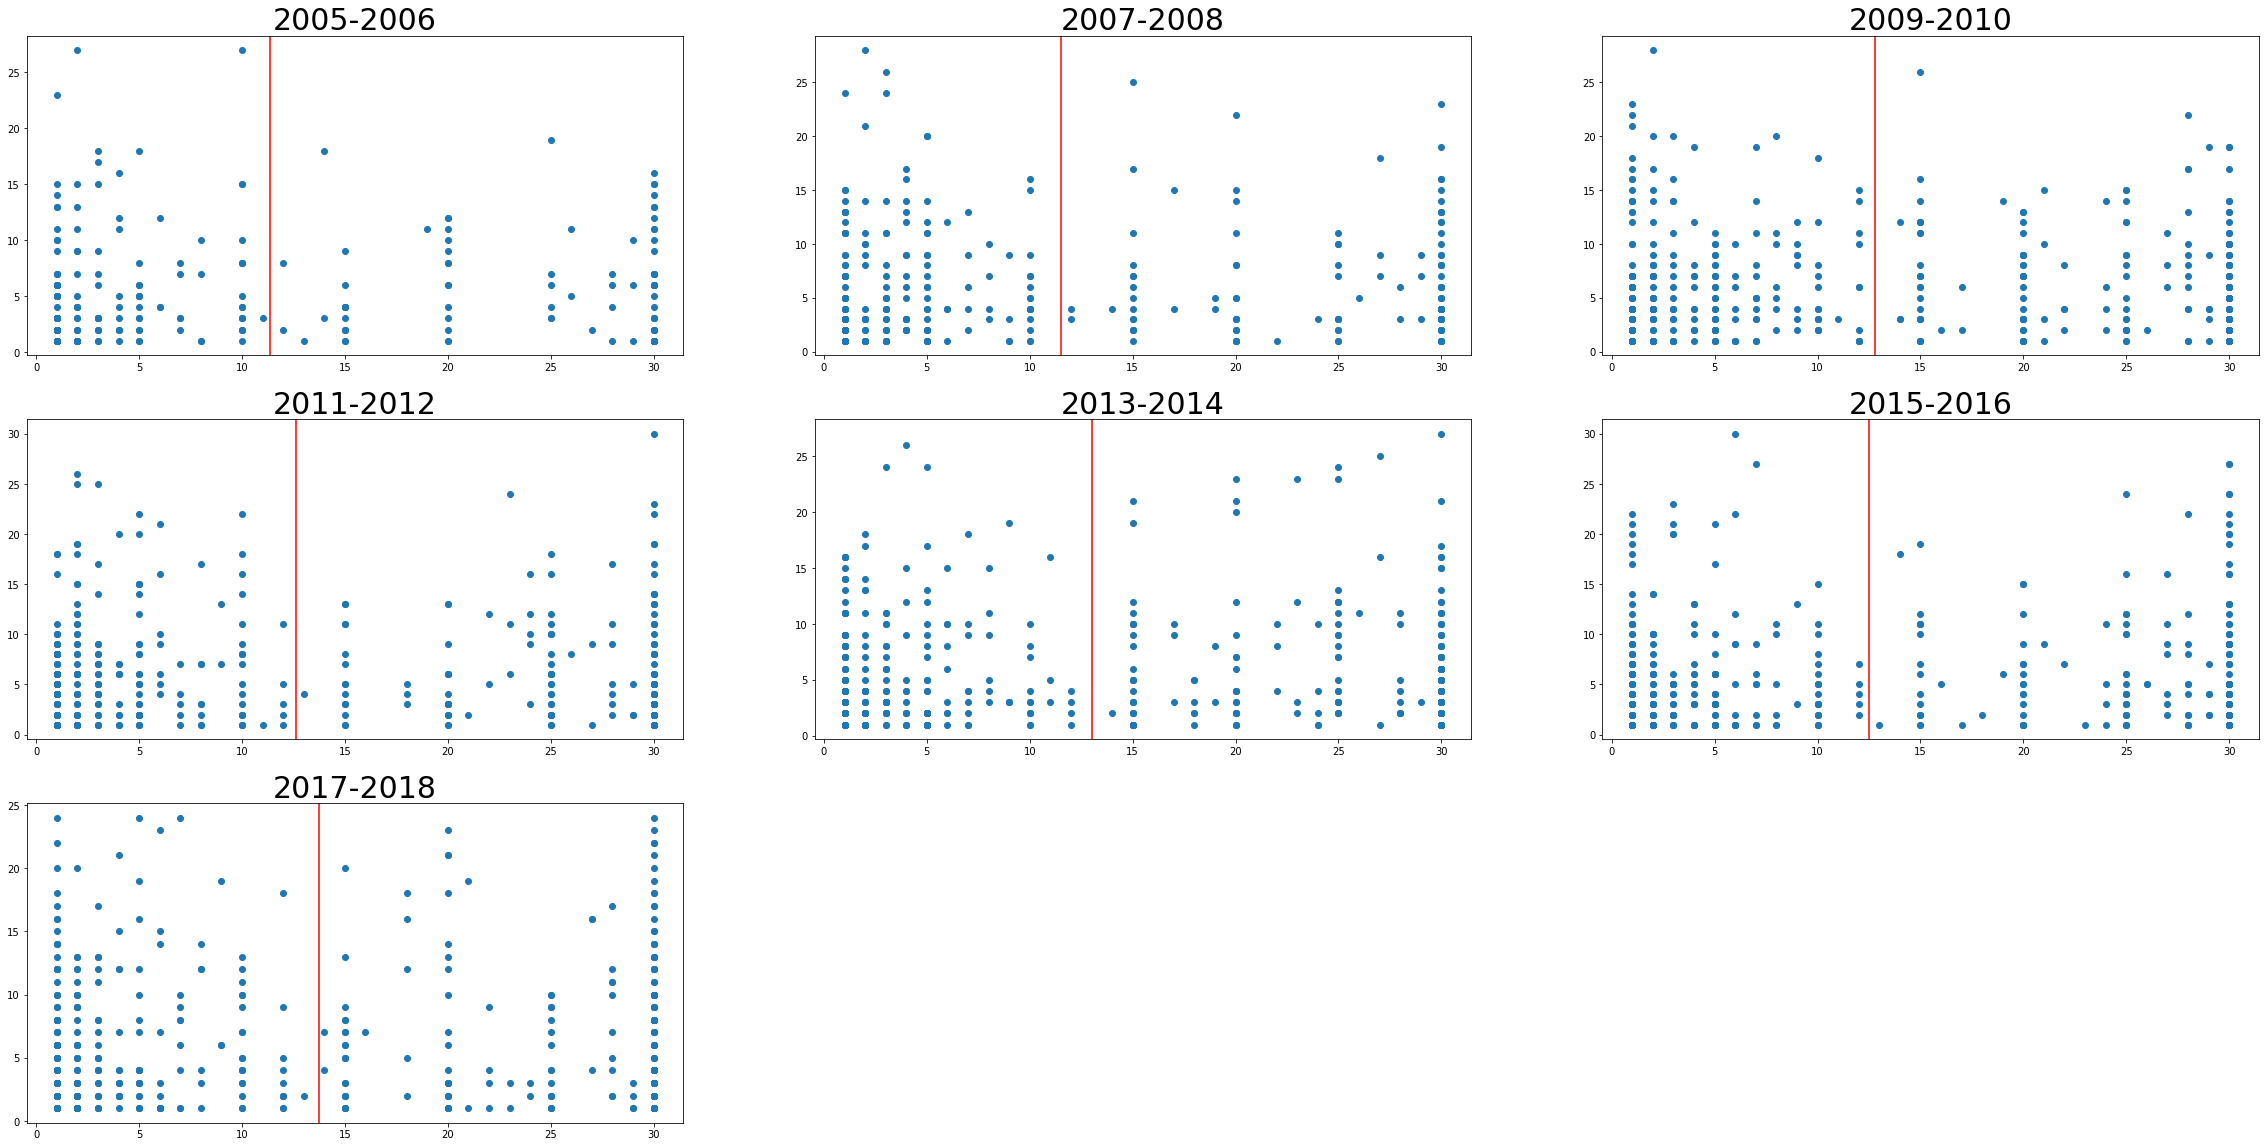

In [17]:
plt.figure(figsize=(40, 20))

rows = cols = 3 

for year in range(1, 8):
    plt.subplot(rows, cols, year)
    table = master_table.loc[master_table['year']==year]
    
    plt.scatter(table['DUQ230'], table['depression_score'])
    
    offset = 2 * year - 1 
    plt.title(f'{2004+offset}-{2005+offset}', fontdict={'size': 30})
    plt.axvline(table['DUQ230'].mean(), color='red')
    
plt.show()